In [2]:
%config IPCompleter.greedy=True
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
os.environ['Bucket'] = "gs://quickdraw_dataset/full/simplified/"

In [3]:
import random
import json
import time
import numpy as np
import pandas as pd
import uuid
import h5py
from multiprocessing import Pool
from glob import glob
from math import ceil
from random import shuffle
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from keras import optimizers as keras_optimizer
from keras import regularizers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Conv1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras_tqdm import TQDMNotebookCallback
from quick_draw_data import QuickDrawDataset as qdd
#from model import QuickDrawModel as qdm

# Pre-Process Quick Draw DataSet

#### Download Random Files

In [4]:
# List the google bucket
urls = !gsutil ls $Bucket

In [5]:
#Specify number of classes
#This will be used globally
num_classes = 10
ndjson_path = './data' 
workers = 8

In [6]:
if not os.path.isdir(ndjson_path):
    os.mkdir(ndjson_path)
    print("created folder: ", ndjson_path)

In [23]:
def download_file(file_name_index):
    file_name = urls[file_name_index]
    print(file_name)
    !gsutil cp "$file_name" ./data

In [24]:
total_files = len(urls)
random_index = [random.randint(0, total_files) for i in range(num_classes)]

In [25]:
ndjson_files = glob(ndjson_path + '/*.ndjson')
download_pool = Pool(workers)

if (len(ndjson_files) > 0 and len(ndjson_files) < num_classes):
    for file in ndjson_files:
        os.unlink(file)
    print(download_pool.map(download_file, random_index))

if (len(ndjson_files) == 0):
    print(download_pool.map(download_file, random_index))

download_pool.close()

#### Quick Draw Data prepration
Class `QuickDrawDataset` convertes `strokes` data in `ndjson  files` to `numpy array` of shape = `(28, 28)`</br>
into a single file named `data.hdf5` with following `datasets`:
- `X_train`, `y_train`
- `X_valid`, `y_valid`
- `X_test`, `y_test`

`QuickDrawDataset.splits` returns `DataGenerator` for train, validation and test sets.</br>
Each iteration over `DataGenerators` gives a tuple containg features and labels of specified batch_size.</br>
Default `batch_size` is 32

#### Visualizing QuickDraw Data

In [27]:
qdd_params = {
        "num_classes":10,
        "workers":10,
        "path":"./data",
        "debug":True,
        "samples_per_class":20000
    }
data = qdd(**qdd_params)

In [31]:
classes, targets  = data.mapping['classes'], data.mapping['targets']
print(json.dumps(classes, indent=2))
print(json.dumps(targets, indent=2))

{
  "skateboard": 8,
  "nose": 5,
  "van": 9,
  "passport": 6,
  "hedgehog": 2,
  "sea turtle": 7,
  "hourglass": 3,
  "house": 4,
  "angel": 0,
  "fan": 1
}
{
  "[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]": "passport",
  "[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]": "angel",
  "[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]": "nose",
  "[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]": "fan",
  "[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]": "hedgehog",
  "[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]": "sea turtle",
  "[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]": "skateboard",
  "[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]": "house",
  "[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]": "van",
  "[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]": "hourglass"
}


In [32]:
train, valid, test = data.splits 

#### TrainSet

In [45]:
x, y = train[2]
x = x[:19] 
y = y[:19]
x = x * 255
x = x.astype(int)

/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


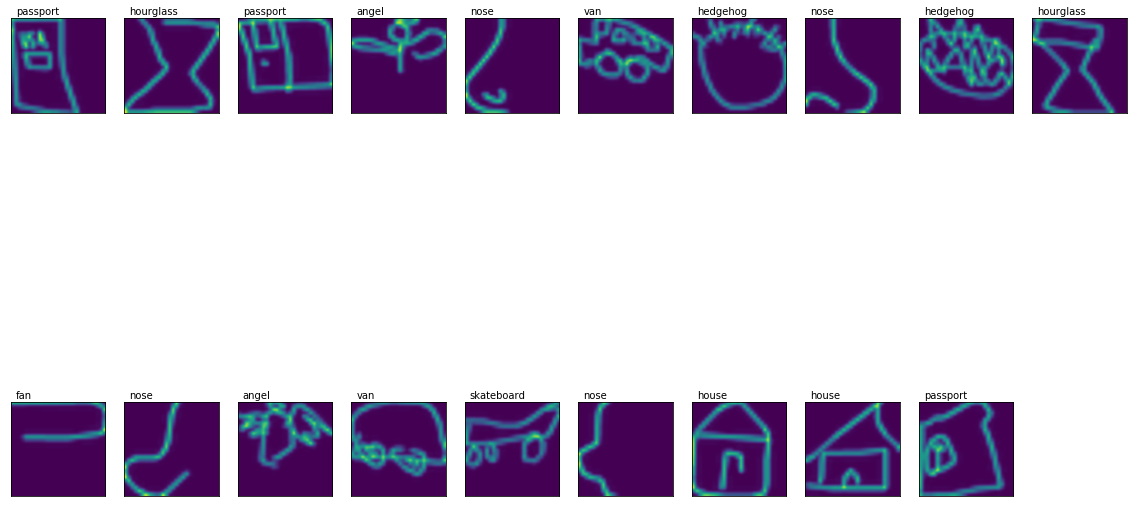

In [46]:
fig = plt.figure(figsize=(20,20))
for i in range(len(x)):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x[i], interpolation="gaussian")

for i in range(len(x)):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.text(1, -1.5,s = targets[str(y[i])])

#### Validation Set

In [43]:
x, y = valid[1]
x = x[:10]
y= y[:16]
x = x * 255
x = x.astype(int)

/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


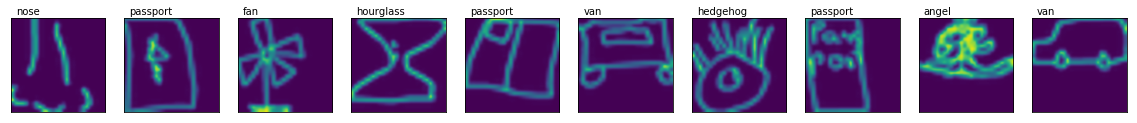

In [44]:
fig = plt.figure(figsize=(20,20))
for i in range(len(x)):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x[i],interpolation="gaussian" )

for i in range(len(x)):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.text(1, -1.5,s = targets[str(y[i])])

#### Test Set

In [ ]:
x, y = test[1]
x = x[:10] 
y = y[:10]
x = x * 255
x = x.astype(int)

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(len(x)):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x[i],interpolation="gaussian" )

for i in range(len(x)):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.text(1, -1.5,s = targets[str(y[i])])

In [32]:
data.clear_files()
data.clear_output()

#### Creating Data for training models

In [15]:
qdd_params = {
        "num_classes":10,
        "workers":12,
        "path":"./data",
        "debug":True,
        "split_spot":80,
        "batch_size":128
    }
data = qdd(**qdd_params)

In [16]:
train,valid,test = data.full_split
train[0].shape, valid[0].shape, test[0].shape

((921706, 28, 28), (230421, 28, 28), (288027, 28, 28))

#### Keras Model

In [7]:
seed = 42
np.random.seed(seed)

In [8]:
from keras import optimizers as kopts

koptimizer = {
    'rms': kopts.RMSprop,
    'sgd': kopts.SGD,
    'adam': kopts.Adam
}

In [9]:
def create_model(layers=(784,), dropout=None, batch_normalizaton=False, l2=None, optimizer='rms', learning_rate=None, initializer=None, activation='relu'):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    
    for units in layers:
        layer = Dense(units, activation=activation)
        
        if l2:
            layer.kernel_regularizer = regularizers.l2(l2)
        if initializer:
            layer.kernel_initializer = initializer
            
        model.add(layer)
        
        if batch_normalizaton:
            model.add(BatchNormalization())
        else:
            if dropout:
                model.add(Dropout(dropout))
    
    model_optimizer = koptimizer.get(optimizer)
    if learning_rate:
        opti = model_optimizer(learning_rate)
    else:
        opti = model_optimizer()
    
    model.add(Dense(10,activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    return model

In [10]:
'''layers = [
    (512,),
    (784,),
    (1000,),
    (100, 100),
    (512, 512),
    (784, 784),
    (512, 100),
    (784, 100)   
]'''
layers = [
    (784,),
    (100, 100),
    (512, 512),
    (784, 784),
    (512, 100),
    (784, 100)  
]

m_optimizers = ['rms', 'adam', 'sgd']
batch_normalizaton = [True, False]
dropouts = [None, 0.1, 0.2, 0.3, 0.4, 0.5]
l2 = [None, 0.0001, 0.001, .01]
learning_rate = [0.0001, 0.001]
initializer = ['glorot_uniform', 'he_normal', 'he_uniform']
epochs = [10, 50, 100, 150]
batch_size = [10, 20, 40, 60, 80, 100]


##### Pluggining in Tensorboard to KerasClassifier

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

class KerasClassifierTensorBoard(KerasClassifier):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fit(self, x, y, log_dir=None, **kwargs):
        cbs = None
        if log_dir is not None:
            params = self.get_params()
            conf = ",".join("{}={}".format(k, params[k])
                            for k in sorted(params))
            conf_dir = os.path.join(log_dir, conf)
            cbs = [TensorBoard(log_dir=conf_dir, histogram_freq=1, batch_size=32, write_graph=True, 
                                                        write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                                                        embeddings_metadata=None, embeddings_data=None, update_freq='epoch')]
        super(KerasClassifierTensorBoard, self).fit(x, y, callbacks=cbs, **kwargs)
        

In [12]:
model = KerasClassifierTensorBoard(build_fn=create_model, epochs=10, verbose=1)

##### Grid Search of layers and neurons

In [ ]:
params = {
    "layers":layers,
    "learning_rate":learning_rate
}
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)


In [ ]:
X, Y = train

In [ ]:
result = grid.fit(X, Y, log_dir='./logs', shuffle=True, validation_data=valid)

In [141]:
result.best_score_ , result.best_params_

(0.16400000000186266, {'layers': (784,), 'learning_rate': 0.001})

In [142]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.161125 (0.110517) with: {'layers': (784,), 'learning_rate': 0.0001}
0.164000 (0.113880) with: {'layers': (784,), 'learning_rate': 0.001}
0.150695 (0.101308) with: {'layers': (100, 100), 'learning_rate': 0.0001}
0.153563 (0.097274) with: {'layers': (100, 100), 'learning_rate': 0.001}
0.159547 (0.103268) with: {'layers': (512, 512), 'learning_rate': 0.0001}
0.116195 (0.048189) with: {'layers': (512, 512), 'learning_rate': 0.001}
0.160516 (0.105176) with: {'layers': (784, 784), 'learning_rate': 0.0001}
0.108234 (0.061091) with: {'layers': (784, 784), 'learning_rate': 0.001}
0.154664 (0.097316) with: {'layers': (512, 100), 'learning_rate': 0.0001}
0.110359 (0.043579) with: {'layers': (512, 100), 'learning_rate': 0.001}
0.161328 (0.107268) with: {'layers': (784, 100), 'learning_rate': 0.0001}
0.154141 (0.111553) with: {'layers': (784, 100), 'learning_rate': 0.001}


In [149]:
result.cv_results_

{'mean_fit_time': array([1724.53827373, 1715.96600294, 1975.39900772, 1964.21502725,
        2282.13483564, 2252.79083872, 2167.25655715, 2153.49948899,
        1815.86613337, 1796.27667236, 1782.69072008, 1770.31185834]),
 'mean_score_time': array([47.56058693, 48.03537806, 30.44440428, 26.67042899, 45.21035973,
        47.04761998, 37.50975561, 37.76122038, 49.91990701, 45.11939128,
        21.95404355, 17.96037467]),
 'mean_test_score': array([0.161125  , 0.164     , 0.15069531, 0.1535625 , 0.15954688,
        0.11619531, 0.16051563, 0.10823438, 0.15466406, 0.11035938,
        0.16132813, 0.15414063]),
 'param_layers': masked_array(data=[(784,), (784,), (100, 100), (100, 100), (512, 512),
                    (512, 512), (784, 784), (784, 784), (512, 100),
                    (512, 100), (784, 100), (784, 100)],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object

### Training a Network with Single Hidden Layer and 784 units | No Regularization

In [9]:
train, valid, test = data.splits

In [166]:
import keras
keras.backend.clear_session()
model = create_model(layers=(784,), learning_rate=0.0001)
cbs = [TensorBoard(log_dir="./logs/MLP_With_Epochs=2", histogram_freq=1, batch_size=32, write_graph=True, 
                    write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                    embeddings_metadata=None, embeddings_data=None, update_freq='batch')]
history = model.fit_generator(generator=train ,validation_data=valid, epochs=2, callbacks=cbs, use_multiprocessing=True )

INFO:plaidml:Opening device "metal_amd_radeon_pro_555x.0"
I0721 01:47:18.780150 140735688254336 library.py:135] Opening device "metal_amd_radeon_pro_555x.0"


Epoch 1/2


/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/numpy/ctypeslib.py:363: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:752: UserWarning: You are not using the TensorFlow backend. histogram_freq was set to 0
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:760: UserWarning: You are not using the TensorFlow backend. write_images was set to False
  warnings.warn('You are 

7200/7200 [==============================] - 643s 89ms/step - loss: 0.7185 - acc: 0.7941 - val_loss: 0.6787 - val_acc: 0.8378
Epoch 2/2
7200/7200 [==============================] - 569s 79ms/step - loss: 0.5330 - acc: 0.8595 - val_loss: 0.5146 - val_acc: 0.8628


In [167]:
scores = model.evaluate_generator(test, verbose=1)

2250/2250 [==============================] - 199s 88ms/step


NameError: name 'socres' is not defined

In [168]:
scores


[0.46486404279205534, 0.8692083333333334]

#### Training a Network with Single Hidden Layer and 784 units with L2 Regularization

In [169]:
import keras
keras.backend.clear_session()
model = create_model(layers=(784,), learning_rate=0.0001, l2=0.001)

INFO:plaidml:Opening device "metal_amd_radeon_pro_555x.0"
I0721 02:11:43.395495 140735688254336 library.py:135] Opening device "metal_amd_radeon_pro_555x.0"
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/numpy/ctypeslib.py:363: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


In [145]:
cbs = [TensorBoard(log_dir="./logs/epochs=2generator", histogram_freq=1, batch_size=32, write_graph=True, 
                    write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                    embeddings_metadata=None, embeddings_data=None, update_freq='batch')]

/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:752: UserWarning: You are not using the TensorFlow backend. histogram_freq was set to 0
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:760: UserWarning: You are not using the TensorFlow backend. write_images was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [146]:
history = model.fit_generator(generator=train ,validation_data=valid, epochs=10, callbacks=cbs, use_multiprocessing=True )

Epoch 1/10
7200/7200 [==============================] - 618s 86ms/step - loss: 0.9877 - acc: 0.7855 - val_loss: 0.7955 - val_acc: 0.8243
Epoch 2/10
7200/7200 [==============================] - 586s 81ms/step - loss: 0.6491 - acc: 0.8438 - val_loss: 0.7214 - val_acc: 0.8462
Epoch 3/10
7200/7200 [==============================] - 565s 78ms/step - loss: 0.5896 - acc: 0.8591 - val_loss: 0.6258 - val_acc: 0.8580
Epoch 4/10
7200/7200 [==============================] - 830s 115ms/step - loss: 0.5557 - acc: 0.8678 - val_loss: 0.6476 - val_acc: 0.8653
Epoch 5/10
7200/7200 [==============================] - 527s 73ms/step - loss: 0.5351 - acc: 0.8738 - val_loss: 0.5428 - val_acc: 0.8705
Epoch 6/10
7200/7200 [==============================] - 496s 69ms/step - loss: 0.5139 - acc: 0.8786 - val_loss: 0.5970 - val_acc: 0.8750
Epoch 7/10
7200/7200 [==============================] - 490s 68ms/step - loss: 0.4983 - acc: 0.8824 - val_loss: 0.5981 - val_acc: 0.8766
Epoch 8/10
7200/7200 [==================

(0, 1)

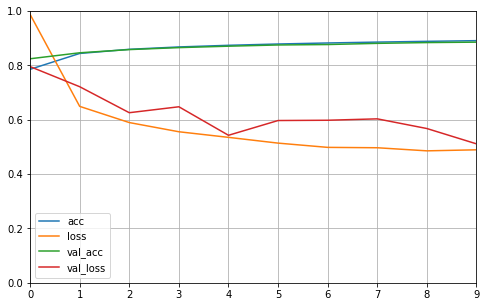

In [162]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [161]:
model.save('MLP_best.h5')

In [150]:
scores = model.evaluate_generator(test, verbose=1)

2250/2250 [==============================] - 140s 62ms/step


In [151]:
scores

[0.4670979449351629, 0.8884479166666667]

In [106]:
_, _, tst = data.splits

In [152]:
x, y  = test[0]

In [153]:
model.predict_classes(x)

array([2, 5, 6, 6, 4, 4, 5, 7, 4, 9, 0, 9, 6, 7, 7, 0, 5, 5, 0, 7, 9, 1,
       3, 5, 0, 9, 4, 3, 6, 0, 3, 5, 9, 5, 6, 8, 6, 0, 5, 8, 2, 7, 4, 5,
       1, 4, 1, 3, 9, 3, 5, 1, 2, 8, 2, 7, 2, 4, 8, 3, 9, 4, 3, 9, 1, 7,
       1, 3, 7, 1, 4, 5, 1, 9, 5, 8, 3, 6, 0, 8, 6, 1, 0, 0, 5, 3, 8, 5,
       2, 1, 1, 1, 6, 7, 8, 2, 9, 2, 7, 0, 9, 4, 0, 5, 7, 4, 0, 5, 2, 2,
       8, 3, 9, 0, 0, 0, 2, 1, 6, 7, 9, 2, 6, 5, 8, 7, 6, 6])

In [154]:
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [155]:
target = data.mapping['targets']
classes =data.mapping['classes']
classes

{'angel': 0,
 'fan': 1,
 'hedgehog': 2,
 'hourglass': 3,
 'house': 4,
 'nose': 5,
 'passport': 6,
 'sea turtle': 7,
 'skateboard': 8,
 'van': 9}

In [156]:
Y = [target[str(i)] for i in y]


In [157]:
Y = [classes[i] for i in Y]

In [159]:
np.array(Y)

array([2, 5, 9, 9, 4, 4, 5, 2, 4, 9, 0, 9, 0, 7, 7, 6, 5, 5, 0, 7, 9, 1,
       3, 5, 7, 9, 4, 3, 6, 6, 3, 5, 9, 5, 6, 8, 6, 3, 5, 8, 2, 2, 4, 5,
       1, 4, 1, 3, 9, 3, 5, 1, 2, 8, 2, 7, 2, 4, 8, 3, 9, 4, 3, 9, 1, 7,
       1, 7, 0, 1, 4, 3, 6, 9, 5, 8, 3, 6, 0, 8, 6, 1, 7, 0, 5, 3, 8, 5,
       2, 1, 1, 1, 2, 7, 8, 2, 5, 2, 7, 0, 9, 4, 0, 5, 7, 4, 0, 5, 1, 2,
       8, 3, 9, 0, 0, 0, 2, 1, 6, 7, 9, 2, 6, 5, 8, 7, 6, 6])

In [160]:
data.mapping

{'classes': {'angel': 0,
  'fan': 1,
  'hedgehog': 2,
  'hourglass': 3,
  'house': 4,
  'nose': 5,
  'passport': 6,
  'sea turtle': 7,
  'skateboard': 8,
  'van': 9},
 'targets': {'[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]': 'van',
  '[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]': 'skateboard',
  '[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]': 'sea turtle',
  '[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]': 'passport',
  '[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]': 'nose',
  '[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]': 'house',
  '[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]': 'hourglass',
  '[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]': 'hedgehog',
  '[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]': 'fan',
  '[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]': 'angel'}}

#### MLP With Batch Normalization

In [11]:
import keras
keras.backend.clear_session()
model = create_model(layers=(784,), learning_rate=0.0001, batch_normalizaton=True)
cbs = [TensorBoard(log_dir="./logs/MLP_With_BN", histogram_freq=1, batch_size=32, write_graph=True, 
                    write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                    embeddings_metadata=None, embeddings_data=None, update_freq='batch')]
history = model.fit_generator(generator=train ,validation_data=valid, epochs=10, callbacks=cbs, use_multiprocessing=True )

INFO:plaidml:Opening device "metal_amd_radeon_pro_555x.0"
I0721 03:26:01.168353 140735688254336 library.py:135] Opening device "metal_amd_radeon_pro_555x.0"
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/numpy/ctypeslib.py:363: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:752: UserWarning: You are not using the TensorFlow backend. histogram_freq was set to 0
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/p

Epoch 1/10
7200/7200 [==============================] - 1007s 140ms/step - loss: 0.5907 - acc: 0.8304 - val_loss: 0.5213 - val_acc: 0.8668
Epoch 2/10
7200/7200 [==============================] - 538s 75ms/step - loss: 0.4659 - acc: 0.8829 - val_loss: 0.4558 - val_acc: 0.8825
Epoch 3/10
7200/7200 [==============================] - 853s 118ms/step - loss: 0.4551 - acc: 0.8977 - val_loss: 0.4870 - val_acc: 0.8870
Epoch 4/10
7200/7200 [==============================] - 569s 79ms/step - loss: 0.3428 - acc: 0.9074 - val_loss: 0.4425 - val_acc: 0.8890
Epoch 5/10
7200/7200 [==============================] - 549s 76ms/step - loss: 0.3320 - acc: 0.9142 - val_loss: 0.4728 - val_acc: 0.8903
Epoch 6/10
7200/7200 [==============================] - 656s 91ms/step - loss: 0.2926 - acc: 0.9198 - val_loss: 0.5395 - val_acc: 0.8904
Epoch 7/10
7200/7200 [==============================] - 561s 78ms/step - loss: 0.2860 - acc: 0.9245 - val_loss: 0.4903 - val_acc: 0.8927
Epoch 8/10
7200/7200 [================

In [12]:
scores = model.evaluate_generator(test, verbose=1)

2250/2250 [==============================] - 205s 91ms/step


In [16]:
model.save('./saved_models/MLP_BatchNormal_epoch=10')

In [26]:
model_ = keras.models.load_model('./saved_models/MLP_BatchNormal_epoch=10')

/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/numpy/ctypeslib.py:363: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


In [27]:
print( model_.evaluate_generator(test, verbose=1))

2250/2250 [==============================] - 104s 46ms/step
[0.3945597800910473, 0.8968576388888889]


#### MLP With Batch Normalization and Epochs=4

In [22]:
import keras
keras.backend.clear_session()
model = create_model(layers=(784,), learning_rate=0.0001, batch_normalizaton=True)
cbs = [TensorBoard(log_dir="./logs/MLP_With_BN_epoch=4", histogram_freq=1, batch_size=32, write_graph=True, 
                    write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                    embeddings_metadata=None, embeddings_data=None, update_freq='batch')]
history = model.fit_generator(generator=train ,validation_data=valid, epochs=4, callbacks=cbs, use_multiprocessing=True)

INFO:plaidml:Opening device "metal_amd_radeon_pro_555x.0"
I0721 05:20:13.588438 140735688254336 library.py:135] Opening device "metal_amd_radeon_pro_555x.0"


Epoch 1/4


/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/numpy/ctypeslib.py:363: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:752: UserWarning: You are not using the TensorFlow backend. histogram_freq was set to 0
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '
/Users/tarik.setia/miniconda3/envs/keras/lib/python3.5/site-packages/keras/callbacks.py:760: UserWarning: You are not using the TensorFlow backend. write_images was set to False
  warnings.warn('You are 

7200/7200 [==============================] - 500s 69ms/step - loss: 0.5800 - acc: 0.8314 - val_loss: 0.5081 - val_acc: 0.8675
Epoch 2/4
7200/7200 [==============================] - 342s 47ms/step - loss: 0.4257 - acc: 0.8823 - val_loss: 0.4283 - val_acc: 0.8838
Epoch 3/4
7200/7200 [==============================] - 467s 65ms/step - loss: 0.3689 - acc: 0.8981 - val_loss: 0.4936 - val_acc: 0.8885
Epoch 4/4
7200/7200 [==============================] - 541s 75ms/step - loss: 0.4643 - acc: 0.9065 - val_loss: 0.4375 - val_acc: 0.8897


In [23]:
scores = model.evaluate_generator(test, verbose=1)

2250/2250 [==============================] - 191s 85ms/step


In [24]:
scores

[0.37913040586312613, 0.8946493055555556]

In [25]:
model.save('./saved_models/MLP_BatchNormal_epoch=4')